In [1]:
import sys
from pathlib import Path
import torch
import logging
import numpy as np
import re
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import datasets
from omegaconf import OmegaConf
from hydra.utils import get_class
import torchaudio
from tqdm import trange, tqdm
from f5_tts.infer.utils_infer import (
    mel_spec_type,
    target_rms,
    cross_fade_duration,
    nfe_step,
    cfg_strength,
    sway_sampling_coef,
    speed,
    fix_duration,
    device,
    infer_process,
    load_model_mdd,
    load_vocoder,
    save_spectrogram,
    preprocess_ref_audio_text,
    remove_silence_for_generated_wav,
)
from f5_tts.model.modules import MelSpec
from f5_tts.model.utils import (
    convert_char_to_pinyin,
    default
)
import pdb
import matplotlib.pyplot as plt

_logger = logging.getLogger(__name__)
logging.basicConfig(encoding='utf-8', level=logging.INFO)

ds_data_path = '/home/xinweic/cached-data/f5-mdd/data'
ds_cache_path = "/home/xinweic/cached-data/f5-mdd/ds-cache"
vocoder_cache_path_model = "/home/xinweic/cached-model/vocoder-cache/F5/models--charactr--vocos-mel-24khz/snapshots/0feb3fdd929bcd6649e0e7c5a688cf7dd012ef21"
datasets.config.DOWNLOADED_DATASETS_PATH = Path(ds_data_path)
datasets.config.HF_DATASETS_CACHE= Path(ds_cache_path)

re_phone = re.compile(r'([@:a-zA-Z]+)([0-9])?(_\w)?')
spec_tokens = set(("<pad>", "<s>", "</s>", "<unk>", "|"))
sil_tokens = set(["sil","SIL","SPN"])

#RE for Teflon files
re_uttid = re.compile(r'(.*/)(.*)\.(.*$)')

#RE for CMU-kids
re_uttid_raw = re.compile(r'(.*)/(.*)\..*')
max_batch = 16



##essential for map fucntion to run with multiprocessing, otherwise deadlock, why?
torch.set_num_threads(1)

def get_audio(audio_in_path, target_rms, target_sample_rate, device):
    audio, sr = torchaudio.load(audio_in_path)
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True) 
    rms = torch.sqrt(torch.mean(torch.square(audio)))
    if rms < target_rms:
        audio = audio * target_rms / rms
    if sr != target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, target_sample_rate)
        audio = resampler(audio)
        
    #return res.to(device=device, dtype=torch.int16), full.to(device=device, dtype=torch.int16)
    return audio.to(device=device)
 
def read_ctm(ctm_path, tokenizer=None):
    ret_dict = {}
    phone_list = []
    cur_uttid = None
    with open(ctm_path, "r") as ifile:
        for line in ifile:
            line = line.strip()
            fields = line.split(' ')
            assert len(fields) == 5
            uttid, start, end, phoneme = fields[0], float(fields[2]), float(fields[2]) + float(fields[3]), fields[4]
            #uttid = uttid.strip("lbi-")
            phoneme = re_phone.match(phoneme).group(1)
            #pid = tokenizer._convert_token_to_id(phoneme)
            if uttid != cur_uttid and cur_uttid is not None:
                ret_dict.update({cur_uttid: phone_list})
                phone_list = []
            cur_uttid = uttid           
            #phone_list.append([pid, start, end])  
            phone_list.append([phoneme, start, end])           
        if not cur_uttid in ret_dict:
            ret_dict.update({cur_uttid: phone_list})
    return ret_dict

def read_trans(tran_path):
    tran_map = {}
    with open(tran_path, "r") as ifile:
        ##to mark different phonemes: e.g "T" in " went to"
        for line in ifile:
            line = line.strip()
            uttid, sent = line.split(' ')[0], line.split(' ')[1:]
            tran_map.update({uttid: (' '.join(sent)).lower()})
    return tran_map

##return a list of phoneme masks for each phoneme, before and after scaled by mask_ratio
def mdd_mask( pid_seq, mask_ratio, mask_all, device):
    length = pid_seq[-1][-1]
    mask_list = []
    mask_list_orig = []
    for index in range(len(pid_seq)):
        mask = torch.full((length,), True, dtype=torch.bool, device=device )
        mask_orig = torch.full((length,), True, dtype=torch.bool, device=device )
        pid, l_orig, r_orig = pid_seq[index]
        if mask_ratio < 1:
            sys.exit("mask_ratio must greater than 1") 
        extend = math.floor((r_orig-l_orig) * (mask_ratio - 1) / 2)
        l = math.floor(l_orig - extend) if l_orig - extend >= 0 else 0
        r = math.ceil(r_orig + extend) if r_orig + extend <= length else length
        mask[l:r] = False ## False == masked!
        mask_orig[l_orig:r_orig] = False
        mask_list.append(mask)
        mask_list_orig.append(mask_orig)
    
    if mask_all:
        mask_list = [ torch.zeros_like(mask, dtype=torch.bool, device=device ) for mask in mask_list]
        ## mask_list_orig needs to be kept for eavalting the GOP in the segment
        #mask_list_orig = [ torch.zeros_like(mask, dtype=torch.bool, device=device ) for mask in mask_list_orig]
        
    return mask_list, mask_list_orig

def read_dur(dur_path):
    dur_list = []
    with open(dur_path, "r") as ifile:
        ##to mark different phonemes: e.g "T" in " went to"
        for line in ifile:
            line = line.strip()
            fields = line.split(' ')
            if len(fields) != 2:
                sys.exit("Kaldi format utt2dur format")
            uttid, dur = fields[0], float(fields[1])
            dur_list.append((uttid, dur))
    return dur_list

## convert resolution from ctm alignment to target dur length
def resol_conversion_duration(pid_seq, dur_target):
    #pdb.set_trace()
    pid_seq_ret = []
    total_len = dur_target
    time_end = [ e for id,s,e in pid_seq ] 
    total_time = time_end[-1]
    frame_end = [ math.ceil((time/total_time)*total_len) for time in time_end ]  ### ceiling for covering a wider range of code in case of phoneme state transition 
    start = 0
    for (pid,_,_),frame_e in zip(pid_seq, frame_end):
        pid_seq_ret.append([pid, start, frame_e])
        start = frame_e - 1  ### -1 for covering a wider range of code in case of phoneme state transition 
    assert pid_seq_ret[-1][-1] == dur_target
    return pid_seq_ret

##return gop_list, gop_diff_list, 1D-list NumP 
def compute_gop(out_probs, out_probs_diff, phoneme_mask_list):
    assert len(out_probs.shape) == 2 ## 2D tensor, B x NumFrame
    np = out_probs.shape[0]
    gop_list = [ out_probs[i][~mask].mean().item() for i, mask in zip(range(np), phoneme_mask_list)]
    gop_list_diff = [ out_probs_diff[i][~mask].mean().item() for i, mask in zip(range(np), phoneme_mask_list)]
    gop_list_diff = [ gop - gop_diff for gop, gop_diff in zip(gop_list, gop_list_diff)]
    return gop_list, gop_list_diff
 
### non-batch version
def get_avg_posterior(model, text_in, cond, pid_seq, cfg_strength_gop=0, diff_symbol=None, mask_all=False, masking_ratio=1, sway_sampling_coef=-1, steps=32, n_samples=5, full_utt=False, compute_prob_exact=False):
    assert cond.shape[-1] == model.num_channels
    duration_mel = cond.shape[-2]
    pid_seq = resol_conversion_duration(pid_seq, dur_target=duration_mel)
    assert masking_ratio >= 1  ###in this version (ODE-solver) only the segment within the phoneme_mask_list are valid 
    phoneme_mask_list, phoneme_mask_list_orig = mdd_mask(pid_seq, masking_ratio, mask_all, device)
    num_phonemes = len(pid_seq)

    if cfg_strength_gop != 0:
        ##dynamic batch_size
        amount = num_phonemes * duration_mel
        max_batch_new = int(num_phonemes*(25000/amount))
    else:
        max_batch_new = 128
    # quo, res = num_phonemes // max_batch_new, num_phonemes % max_batch_new
    # if res <= 0.5 * max_batch_new:
    #     iter_num = quo if quo > 0 else 1
    # else:
    #     iter_num = quo + 1
    iter_num = (num_phonemes) // max_batch_new + 1
    count = 0
    gop = torch.rand((0), device=device)
    gop_diff = torch.rand((0), device=device)
    for i in range(iter_num):
        b_size = max_batch_new if i != iter_num-1 else num_phonemes-count
        if b_size == 0:
            continue
        phoneme_mask_in = phoneme_mask_list[count:count+b_size]
        phoneme_mask_list_orig_in = phoneme_mask_list_orig[count:count+b_size]
        input_kwargs = dict(
                    mel_target=[cond] * b_size,
                    text=[text_in] * b_size, 
                    duration = duration_mel,
                    steps = steps,
                    cfg_strength = cfg_strength_gop,
                    phoneme_mask_list = phoneme_mask_in,
                    phoneme_mask_list_orig = phoneme_mask_in if mask_all else phoneme_mask_list_orig_in,
                    diff_symbol = diff_symbol,
                    sway_sampling_coef = sway_sampling_coef,
                    n_samples = n_samples,           
            )
        ## Hut approximation, directly return aggreagated probability for each phoneme
        if not full_utt:
            if not compute_prob_exact:
                gop_temp, gop_diff_temp = model.compute_prob_hut_mask( **input_kwargs)
            else:
                input_kwargs.pop("phoneme_mask_list_orig")
                input_kwargs.pop("n_samples")
                input_kwargs["t_inerval"] = 64
                gop_temp, gop_diff_temp = model.compute_prob_plot_nocache( **input_kwargs)       
        else:
            gop_temp, gop_diff_temp = model.compute_prob_hut_fullutt_plot( **input_kwargs)
        gop = torch.concat((gop,gop_temp))
        gop_diff = torch.concat((gop_diff,gop_diff_temp))
        #log_prob_y0, log_prob_y0_null = model.compute_prob_non_batch( **input_kwargs)
        count += b_size          
    ##return gop_list, gop_diff_list, 1D-list NumP 
    if compute_prob_exact:
        ## return per frame likelihood
        return gop, gop_diff, phoneme_mask_list_orig
    else:
        gop_diff = gop - gop_diff
        return gop.tolist(), gop_diff.tolist()
  

/home/xinweic/miniconda3/envs/f5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
 ## load model config       
yaml_path = "./f5_tts/configs/F5TTS_v1_Base.yaml"
model_cfg = OmegaConf.load(yaml_path)
mel_spec_type = model_cfg.model.mel_spec.mel_spec_type 
## paramters
target_rms = 0.1
target_sample_rate = model_cfg.model.mel_spec.target_sample_rate
hop_length = model_cfg.model.mel_spec.hop_length
win_length = model_cfg.model.mel_spec.win_length
n_fft = model_cfg.model.mel_spec.n_fft
n_mel_channels = model_cfg.model.mel_spec.n_mel_channels
frames_per_second = target_sample_rate // hop_length
#load vocab and tokenizer
tokenizer = model_cfg.model.tokenizer
vocab_path = "./F5_model/F5TTS_v1_Base/vocab.txt"

## load model
model_path = "./F5_model/F5TTS_v1_Base/model_1250000.safetensors"
model_cls = get_class(f"f5_tts.model.{model_cfg.model.backbone}")
model_arc = model_cfg.model.arch    
model_name = model_cfg.model.name
print(f"Using {model_name}...")

def batch_process(uid, text, mel, pid_seq, device):
    model = load_model_mdd( model_cls, model_arc, model_path, mel_spec_type=mel_spec_type, vocab_file=vocab_path, device=device, use_ema=True)
    dtype = next(model.parameters()).dtype
    mel = mel.to(dtype=dtype)
    ###to save memory for MDD
    for param in model.parameters():
        param.requires_grad = False   
    ##mdd parameters:
    cfg_strength_gop=0
    #diff_symbol="p"
    diff_symbol=None
    mask_all = False
    masking_ratio=1
    steps=8
    n_samples=10
    sway_sampling_coef = None
    full_utt = False
    compute_prob_exact = True
    #sway_sampling_coef = -1
    
    print(f"Using full_utt={full_utt}, mask_all={mask_all}, cfg={cfg_strength_gop}, mr={masking_ratio}, steps={steps}, sway={sway_sampling_coef}, diff={diff_symbol}")
    #We need training mode because ODE?
    #model.eval()
    with torch.no_grad():
        print("processing {0}".format(uid))    
        gop_list, gop_diff_list, mask = get_avg_posterior(model, text, mel, pid_seq, cfg_strength_gop=cfg_strength_gop, diff_symbol=diff_symbol, mask_all=mask_all, masking_ratio=masking_ratio, sway_sampling_coef=sway_sampling_coef, steps=steps, n_samples=n_samples, full_utt=full_utt, compute_prob_exact=compute_prob_exact)       
        return gop_list, gop_diff_list, mask
        ### write files      
        # f.write(uid+'\n')
        # for i, (gop, gop_diff) in enumerate(zip(gop_list ,gop_diff_list)):
        #     f.write("%d %s %s %s\n"%(i, pid_seq[i][0], gop, gop_diff))
        # f.write("\n")

Using F5TTS_v1_Base...


In [3]:
 ## mask and gen
audio_in_path = Path("../test/cat.wav")
trans = "cat."
#trans = "illness."
cond = get_audio(audio_in_path, target_rms, target_sample_rate, device)
duration_mel = math.ceil(cond.shape[-1] / hop_length)

mel_spec_kwargs=dict(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    n_mel_channels=n_mel_channels,
    target_sample_rate=target_sample_rate,
    mel_spec_type=mel_spec_type,
)
mel_spec = MelSpec(**mel_spec_kwargs)
mel = mel_spec(cond)
mel = mel.permute(0, 2, 1).squeeze()
#pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.2], ['AE', 0.2, 0.8], ['T', 0.8, 0.9], ['SIL', 0.9, 1]]
#cat
pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.29], ['AE', 0.29, 0.5], ['T', 0.5, 0.9], ['SIL', 0.9, 1]]
#cit	
#pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.46], ['AE', 0.46, 0.6], ['T', 0.6, 0.9], ['SIL', 0.9, 1]]
#cot
#pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.43], ['AE', 0.43, 0.6], ['T', 0.6, 0.9], ['SIL', 0.9, 1]]

gop_list, gop_diff_list, mask_plot = batch_process(trans, trans, mel, pid_seq_sec, device)
# new_folder = os.path.dirname(out_path)


vocab :  ./F5_model/F5TTS_v1_Base/vocab.txt
token :  custom
model :  ./F5_model/F5TTS_v1_Base/model_1250000.safetensors 

Using full_utt=False, mask_all=False, cfg=0, mr=1, steps=8, sway=None, diff=None
processing cat.


ODE MDD: 0it [00:00, ?it/s]/home/xinweic/miniconda3/envs/f5/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_scaled_dot_product_flash_attention_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/xinweic/miniconda3/envs/f5/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::mish_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the 

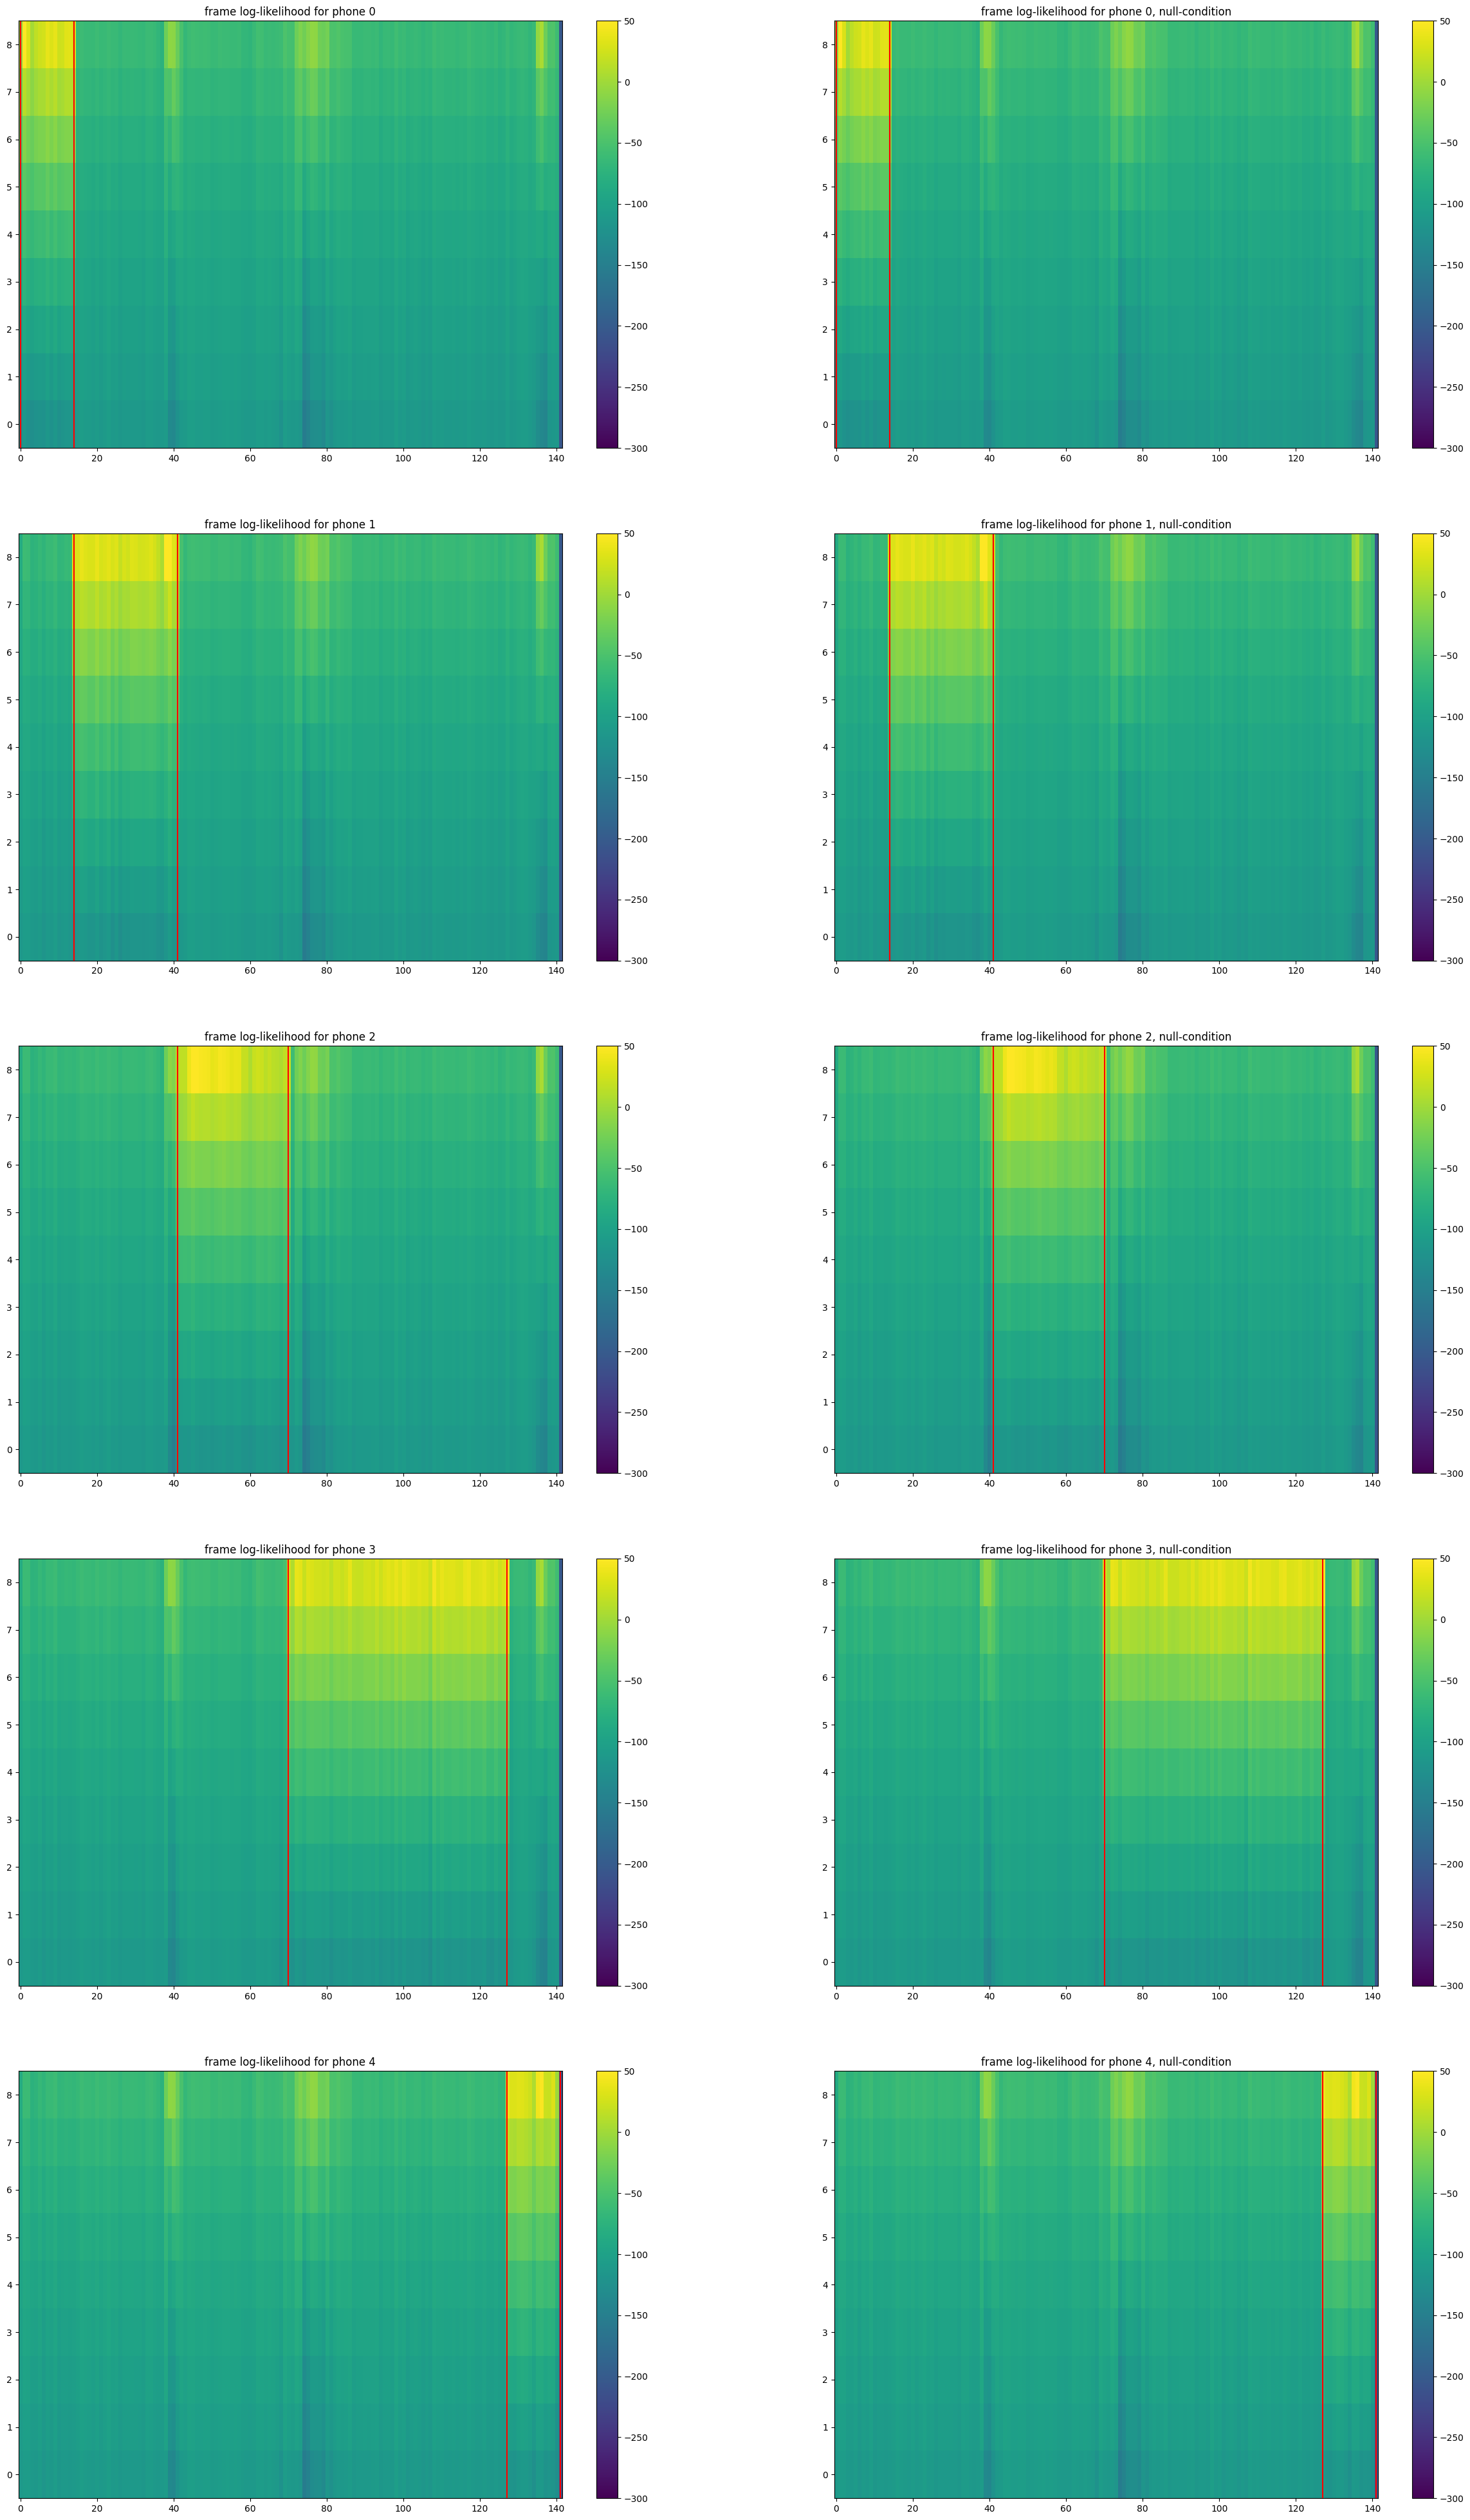

In [4]:
%matplotlib inline
def get_segment(mask):
    l = torch.where(mask == False)[0][0]
    r = torch.where(mask == False)[0][-1]
    return l.item(),r.item()
gop_list = gop_list.cpu()
gop_diff_list = gop_diff_list.cpu()
p_num = gop_list.shape[1]
fig, axes = plt.subplots(p_num,2,figsize=(30, 10*p_num))
for i in range(p_num):
    l,r = get_segment(mask_plot[i])
    im = axes[i,0].imshow(gop_list[:,i,:],cmap='viridis', origin='lower',  aspect='auto', vmin=-300, vmax=50)
    axes[i,0].axvline(l, color="r")
    axes[i,0].axvline(r, color="r")
    axes[i,0].set_title(f"frame log-likelihood for phone {i}")
    fig.colorbar(im, ax=axes[i,0] )
    im_diff = axes[i,1].imshow(gop_diff_list[:,i,:], cmap='viridis', origin='lower',  aspect='auto', vmin=-300, vmax=50)
    axes[i,1].axvline(l, color="r")
    axes[i,1].axvline(r, color="r")
    axes[i,1].set_title(f"frame log-likelihood for phone {i}, null-condition")
    fig.colorbar(im_diff, ax=axes[i,1])

plt.show()


vocab :  ./F5_model/F5TTS_v1_Base/vocab.txt
token :  custom
model :  ./F5_model/F5TTS_v1_Base/model_1250000.safetensors 

Using full_utt=False, mask_all=False, cfg=0, mr=1, steps=8, sway=None, diff=None
processing illness.


ODE MDD: 8it [08:41, 65.14s/it]
ODE MDD: 8it [08:42, 65.33s/it]


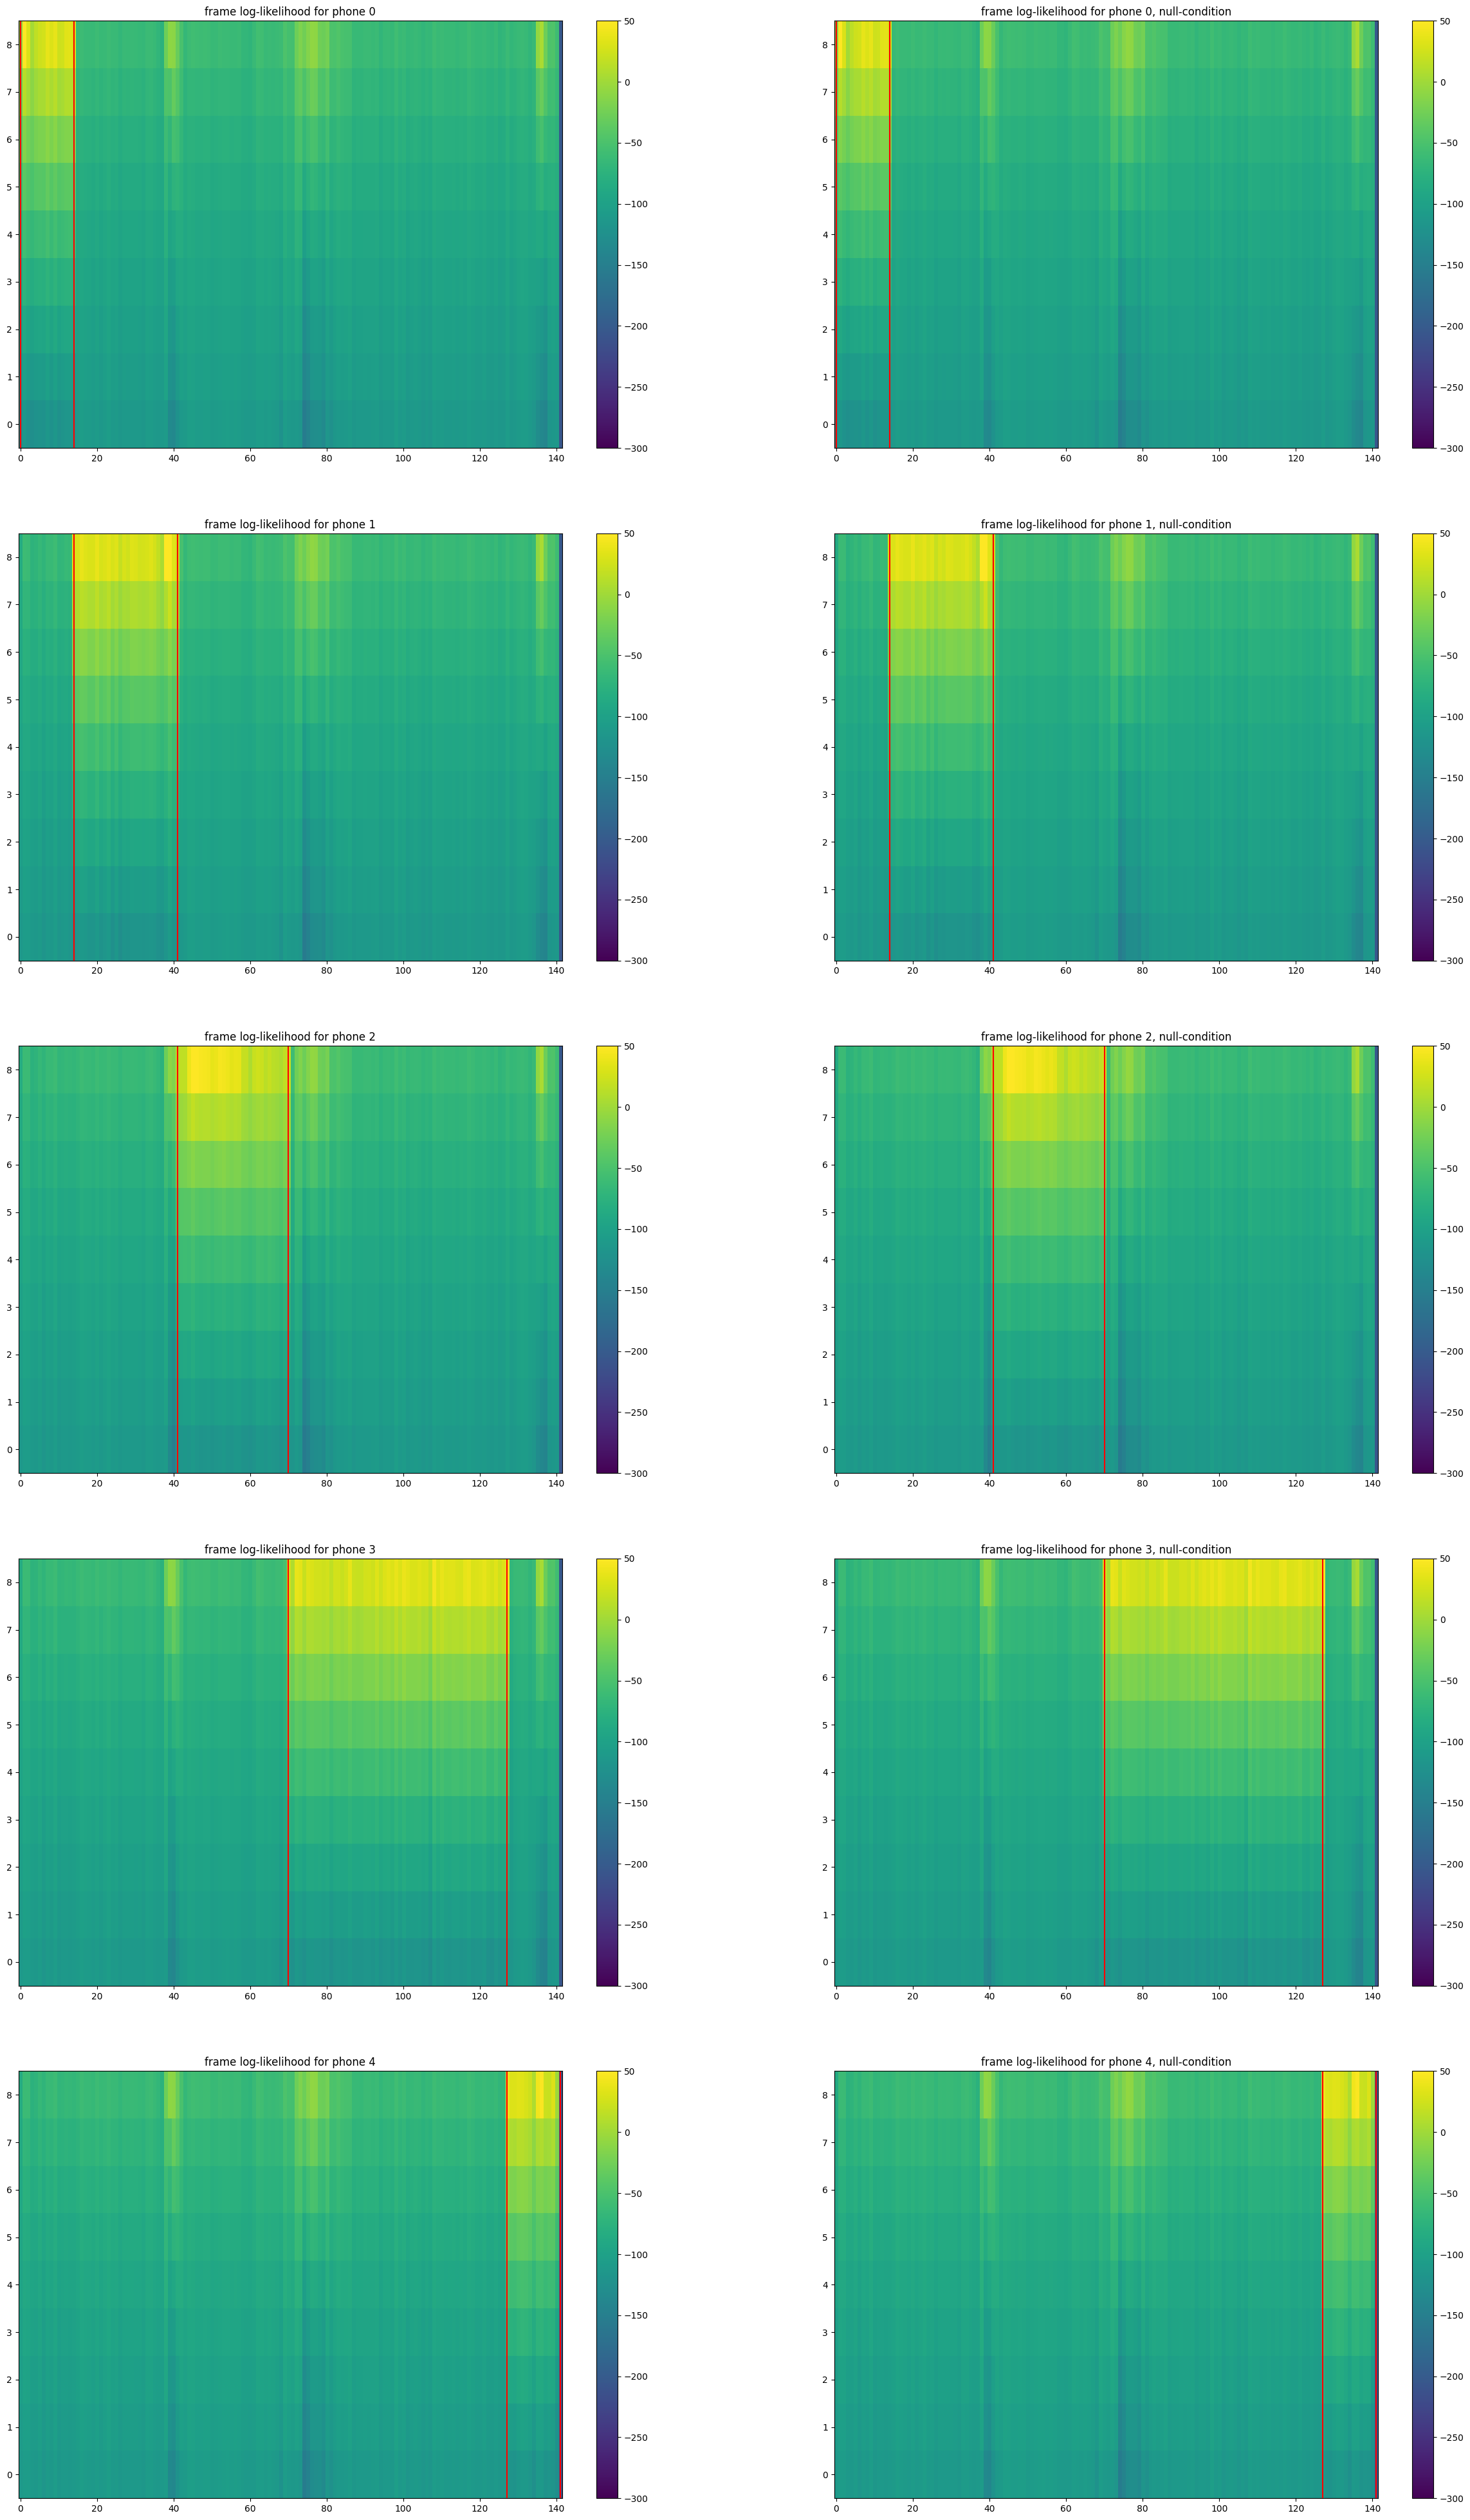

In [5]:
 ## mask and gen
audio_in_path = Path("../test/cat.wav")
trans = "illness."
cond = get_audio(audio_in_path, target_rms, target_sample_rate, device)
duration_mel = math.ceil(cond.shape[-1] / hop_length)

mel_spec_kwargs=dict(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    n_mel_channels=n_mel_channels,
    target_sample_rate=target_sample_rate,
    mel_spec_type=mel_spec_type,
)
mel_spec = MelSpec(**mel_spec_kwargs)
mel = mel_spec(cond)
mel = mel.permute(0, 2, 1).squeeze()
#pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.2], ['AE', 0.2, 0.8], ['T', 0.8, 0.9], ['SIL', 0.9, 1]]
#cat
pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.29], ['AE', 0.29, 0.5], ['T', 0.5, 0.9], ['SIL', 0.9, 1]]
#cit	
#pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.46], ['AE', 0.46, 0.6], ['T', 0.6, 0.9], ['SIL', 0.9, 1]]
#cot
#pid_seq_sec = [['SIL', 0.0, 0.1], ['K', 0.1, 0.43], ['AE', 0.43, 0.6], ['T', 0.6, 0.9], ['SIL', 0.9, 1]]

gop_list_ill, gop_diff_list_ill, mask_plot= batch_process(trans, trans, mel, pid_seq_sec, device)
# new_folder = os.path.dirname(out_path)

%matplotlib inline
def get_segment(mask):
    l = torch.where(mask == False)[0][0]
    r = torch.where(mask == False)[0][-1]
    return l.item(),r.item()
gop_list = gop_list.cpu()
gop_diff_list = gop_diff_list.cpu()
p_num = gop_list.shape[1]
fig, axes = plt.subplots(p_num,2,figsize=(30, 10*p_num))
for i in range(p_num):
    l,r = get_segment(mask_plot[i])
    im = axes[i,0].imshow(gop_list[:,i,:],cmap='viridis', origin='lower',  aspect='auto',  vmin=-300, vmax=50)
    axes[i,0].axvline(l, color="r")
    axes[i,0].axvline(r, color="r")
    axes[i,0].set_title(f"frame log-likelihood for phone {i}")
    fig.colorbar(im, ax=axes[i,0] )
    im_diff = axes[i,1].imshow(gop_diff_list[:,i,:], cmap='viridis', origin='lower',  aspect='auto',  vmin=-300, vmax=50)
    axes[i,1].axvline(l, color="r")
    axes[i,1].axvline(r, color="r")
    axes[i,1].set_title(f"frame log-likelihood for phone {i}, null-condition")
    fig.colorbar(im_diff, ax=axes[i,1])
plt.show()